# Intro to AI-driven Science on Supercomputers

## Week 2 Homework

#### Dan Horner (danhorner@berkeley.edu)
---

# Hyper-parameter search

In this homework we tried to improve model performance through hyper-parameter tuning. 

My high-level aproach is to randomly choose hyper-parameters, and keep track of how well each set performs.

While there are many hyper-parameters that can be tuned and many ways that they can be selected, randomly picking is a straightforward and reasonable choice for this assignment. 

Our model has four hyper-parameters to tune:
- dimension of the hidden layer
- scaling of initial model weights
- learning rate
- batch size

An alternate approach could be to select each hyper-parameter from an evenly-spaced$^*$ grid of values that span the range we wish to consider. To fully explore the space of these hyper-parameters with $n$ values for each hyper-parameter would require $n^4$ training runs-this scaling quickly becomes impractical as more hyper-parameters are considered. A random search, while not guaranteed, is likely to explore the entire hyper-parameter space. Of course, more elaborate strategies can be devised (and many have been implemented in various libraries) to narrow the search and focus on where the best accuracy is found.

In the homework I have only considered the two-layer model presented in class; however, this approach is straightforward to extend to models with more layers by selecting additional hyper-parameters controling them (e.g., number of hidden layers, the dimansion of each hidden layer, etc.)

$^*$The range for some hyper-parameters may span several orders of magnitude, e.g., learning rate, and it may make more sense to choose evently spaced values for the $log$ of that hyper-parameter.


## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
np.random.seed(1)

# Plotting library
import plotnine as p9
from plotnine import * 
p9.options.figure_size = (15, 12)

---

## Function definitions

In [3]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [4]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = np.argmax(scores, axis=1)
    N = predictions.shape[0]
    acc = (true_values == predictions).sum() / N
    return acc

In [5]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights
    return model

In [6]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    model = sgd(model, gradients, learning_rate)
    return loss, model

---

## Data Preparation

The data preparation consists of the following steps:
1. Load the MNIST dataset (training and test sets)
2. Do a bit of data type setting
3. Normalize the values to be in [0, 1] as they were originally in [0, 255]
4. Further split the original training dataset (`X_train_orig` and `y_train_orig`) into the training (80%) and validation (20%) datasets we will use here.


In [7]:
# Repeating the data prep from the in-class notebook

(x_train_orig, y_train_orig), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_orig = x_train_orig.astype(np.float32)
x_test  = x_test.astype(np.float32)

# Normalize values [0-1]
x_train_orig /= 255.
x_test  /= 255.

x_train_orig = x_train_orig.reshape(x_train_orig.shape[0], np.prod(x_train_orig[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test[0,:,:].shape))

y_train_orig = y_train_orig.astype(np.int32)
y_test  = y_test.astype(np.int32)

#Train / validation split
x_train_i, x_val, y_train_i, y_val = train_test_split(x_train_orig, y_train_orig, test_size=0.2)

print('MNIST data loaded: train:',len(x_train_orig),'test:',len(x_test))
print('X_train:', x_train_i.shape)
print('y_train:', y_train_i.shape)
print('X_val:', x_val.shape)
print('y_val:', y_val.shape)
print('X_test:', x_test.shape)
print('y_test:', y_test.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot_i = tf.keras.utils.to_categorical(y_train_i, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

MNIST data loaded: train: 60000 test: 10000
X_train: (48000, 784)
y_train: (48000,)
X_val: (12000, 784)
y_val: (12000,)
X_test: (10000, 784)
y_test: (10000,)


---

## Random Hyper-Parameter Search

Below is where we loop over and traint `n_search` different models, each with different hyper-parameters randomly selected uniformly across pre-defined ranges.
After each model is trained for `num_epochs`, the accuracy for the validation dataset is evaluated and saved along with the hyper-parameters for that run.

In [8]:
%%time

# Number of models to try
n_search = 200
# Number of epochs to run to and evaluate accuracy
num_epochs = 50


# range of hiddlen-layer dimension to sample
hd_rng = (100, 2000)
# range of weight scalings to sample
ws_rng = (0.01, 0.20)
# range of learning rates to sample
learning_rate_rng = (0.025, 0.50) 
# range of batch size to sample
batch_size_rng = (100, 2000)


# Initialize the accuracy
best_acc = 0.0

#list to store hyper-parameters and accuracy for each random model
li_runs = []

for ival in range(n_search):
    print('Currently on step', ival + 1, 'of', n_search, end="\r")

    # Choose random hyper-parameters
    hd = int(np.random.uniform(low = hd_rng[0], high = hd_rng[1]))
    ws = np.random.uniform(low = ws_rng[0], high = ws_rng[1])
    learning_rate = np.random.uniform(low = learning_rate_rng[0], high = learning_rate_rng[1])
    batch_size = int(np.random.uniform(low = batch_size_rng[0], high = batch_size_rng[1]))

    x_train = x_train_i.copy()
    y_train = y_train_i.copy()
    y_train_onehot = y_train_onehot_i.copy()

    num_features = x_train.shape[1]

    num_examples = x_train.shape[0]
    num_batches = int(num_examples / batch_size)

    model = TwoLayerNet(input_dim=num_features, hidden_dim=hd, num_classes=nb_classes, weight_scale=ws)

    losses = np.zeros(num_batches*num_epochs,)
    indices = np.arange(num_examples)

    i = 0
    for epoch in range(0, num_epochs):
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches):
            # grabbing the next batch
            offset = step * batch_size
            batch_range = range(offset, offset+batch_size)
            x_train_batch = x_train[batch_range, :]
            y_train_batch = y_train_onehot[batch_range,:]
        
            # feed the next batch in to do one sgd step
            loss, model = learn(model, x_train_batch, y_train_batch, learning_rate)
            losses[i] = loss
            i += 1
   
        # reshuffle the data so that we get a new set of batches
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices,:]
    
    # Accuracy for comparing models is based on validation data
    acc = accuracy(model, x_val, y_val)
    # Save the current hyper-parameters and accuracy
    li_runs.append((ival, hd, ws, learning_rate, batch_size, acc)) 
    # Keep the best hyper-parameters and model
    if(acc > best_acc):
        best_acc = acc
        best_params = (hd, ws, learning_rate, batch_size)
        best_model = model

print('\nModel search complete')
df_runs = pd.DataFrame(li_runs, columns = ['i', 'hd', 'ws', 'lr', 'bs', 'acc'])

#Save the results off since my laptop is relatively slow (almost 11 hours for 200 models (50 epochs each)
#df_runs.to_csv('./rand-hp_search.csv', index = False)

Currently on step 200 of 200
Model search complete
CPU times: user 1d 17h 9min 58s, sys: 1h 35min 32s, total: 1d 18h 45min 31s
Wall time: 10h 46min 20s


## Resulting model accuracy

I evaluated 200 models and found a best validation accuracy of 0.98017, which is a vast imporvement over 0.44 for the in-class model. Furthermore, the test accuracy (not used for any part of the training) is 0.9805, so it seems as we haven't over-fit the model. 

In [45]:
print('Random hyper-parameter search')
print('N models:', df_dat.index.max() + 1)
print('')
print('Best performing hyper-parameters (hidden-dim, weight scale, learning rate, batch size):')
print(best_params)
print('')
print('Validation accuracy:', accuracy(best_model, x_val, y_val).round(5))
print('Test accuracy      :', accuracy(best_model, x_test, y_test).round(5))

Random hyper-parameter search
N models: 200

Best performing hyper-parameters (hidden-dim, weight scale, learning rate, batch size):
(1613, 0.014875350514585496, 0.3803944921942103, 306)

Validation accuracy: 0.98017
Test accuracy      : 0.9805


---

## Tuning progression

Finally, I have plotted the validation accuracy of each model training run (0-199). In the chart, the larger white points indicate the models that were the current best up until that time.

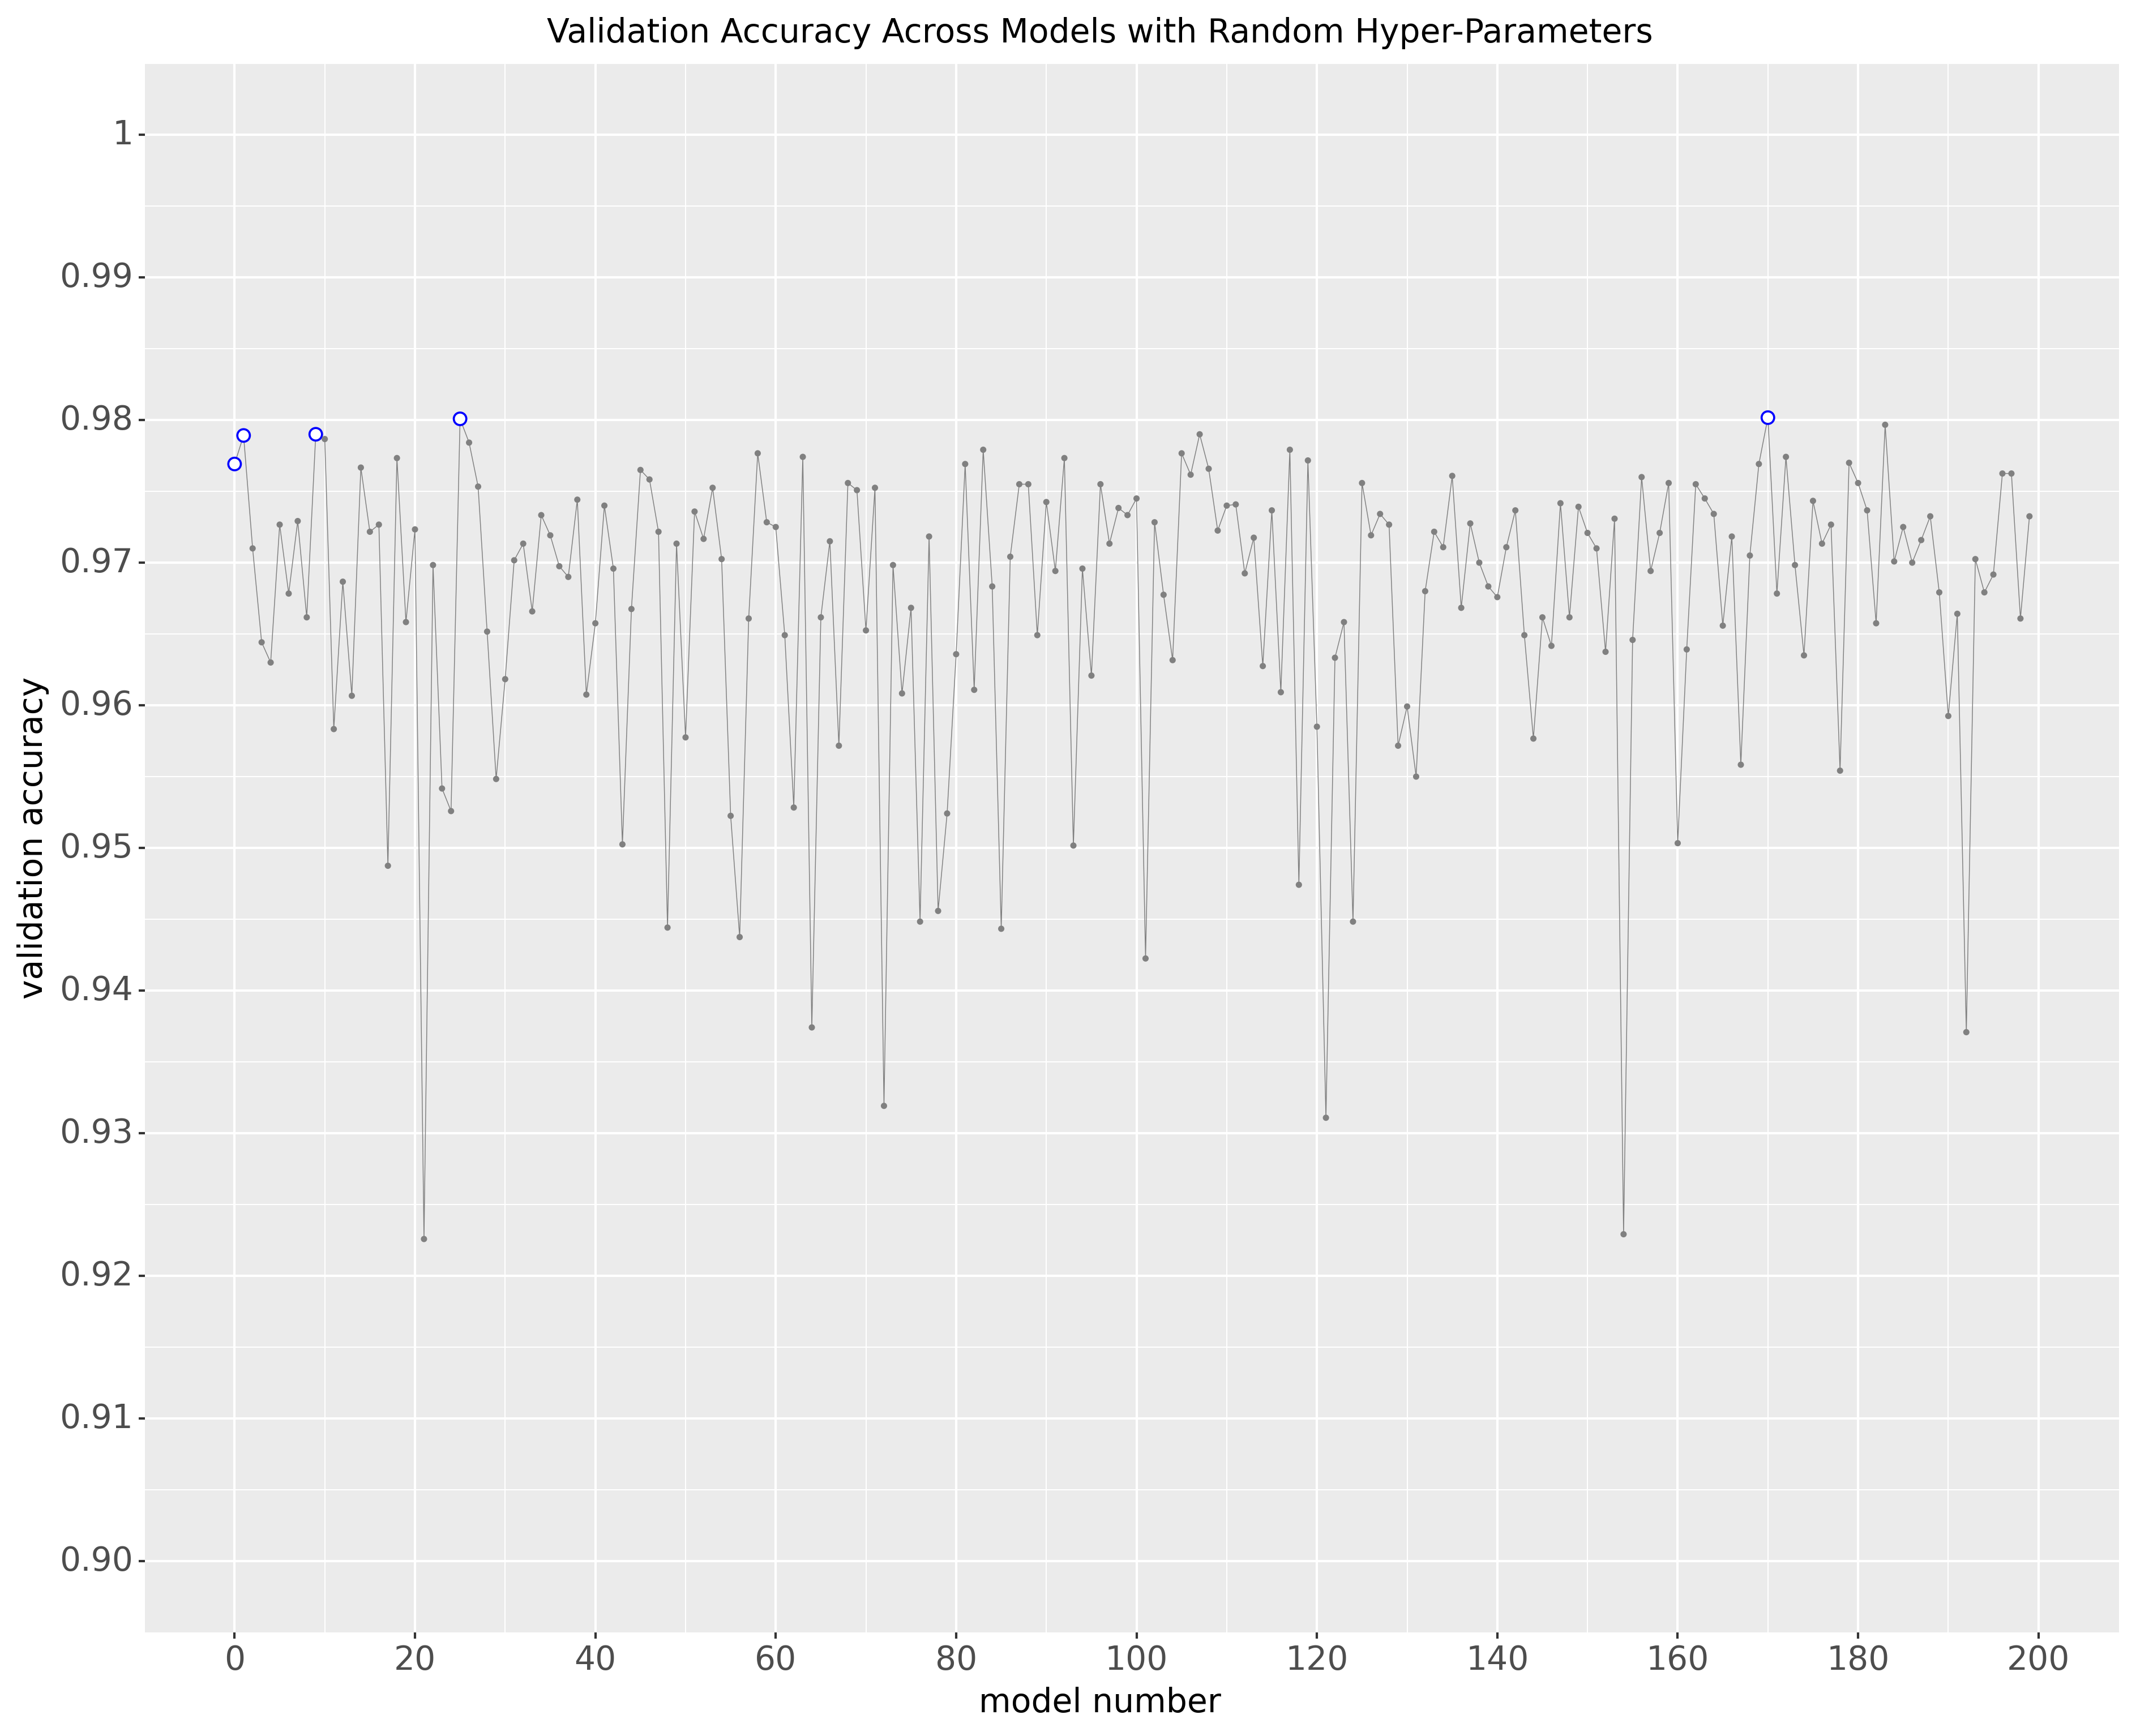

In [50]:
df_pl = pd.read_csv('./rand-hp_search.csv')
df_pl['best'] = 1
for i in df_pl.index[1:]:
    a = df_pl.loc[:, 'acc']
    df_pl.loc[i, 'best'] = (a[i] > a[:i].max()) * 1
df_pl['best'] = df_pl['best'].astype(str)
    
pl = (ggplot()
      + geom_line(df_pl, aes(x = 'i', y = 'acc'), colour = 'grey', size = 0.2)
      + geom_point(df_pl, aes(x = 'i', y = 'acc', colour = 'best', fill = 'best', size = 'best'))
      + scale_x_continuous(name = 'model number', breaks = np.arange(0, 201, 20))
      + scale_y_continuous(name = 'validation accuracy', limits = (0.9, 1), breaks = np.arange(0.9, 1.01, 0.01), minor_breaks = np.arange(0.9, 1.01, 0.005))
      + scale_colour_manual(name = '', values = {'0': 'grey', '1': 'blue'})
      + scale_fill_manual(name = '', values = {'0': 'grey', '1': 'white'})
      + scale_size_manual(name = '', values = {'0': 0.5, '1': 2.5})
      + theme(
          legend_position='none',
          text = element_text(size = 14),
          dpi = 300,
      )
      + ggtitle('Validation Accuracy Across Models with Random Hyper-Parameters')
     )
print(pl)


In [51]:
# Printing out the best model as the tuning progresses
print("Successive 'best' models:")
print(df_pl[df_pl['best'] == '1'].drop(columns = ['best']).to_string(index = False))

Successive 'best' models:
  i   hd       ws       lr  bs      acc
  0 1309 0.129811 0.314810 135 0.976917
  1 1473 0.017908 0.298508 396 0.978917
  9 1073 0.058011 0.456183 295 0.979000
 25 1461 0.035608 0.465532 236 0.980083
170 1613 0.014875 0.380394 306 0.980167
